In [1]:
import sys
parent_path = "/home/jan/Documents/masterthesis/project/mucus"
sys.path.append(parent_path)

import numpy as np
from polymer import Config, Polymer
import toml
import matplotlib.pyplot as plt
from numba import njit
import time
import datetime
import mpltex
import os
import mdtraj as md

#### From trajectories, and distance-matrix trajectories calculate all relevant observables

##### (1) Load the system 

In [2]:
# create list of system filenames

names = ('chain_testForces_50beads_1Msteps', 'box_testCharges_100beads_1Msteps')
dir_data = '/home/jan/Documents/masterthesis/project/mucus'

# first add 2-chain traj
cfg_fnames = list(())
cfg_fnames.append(dir_data+'/configs/box/test/cfg_box_twoChains_140beads_2Msteps.toml')
traj_fnames = list(())
traj_fnames.append(dir_data + '/trajectories/box/test/traj_box_twoChains_140beads_2Msteps.gro')
dist_fnames = list(())
dist_fnames.append(dir_data + '/distances/box/test/dist_box_twoChains_140beads_2Msteps.npy')

for name in names:
    for i in range(4):
        cfg_fname = f'{dir_data:s}/configs/box/test/cfg_{name:s}_{i:d}.toml'
        traj_fname = f'{dir_data:s}/trajectories/box/test/traj_{name:s}_{i:d}.gro'
        dist_fname = f'{dir_data:s}/distances/box/test/dist_{name:s}_{i:d}.npy'
        
        cfg_fnames.append(cfg_fname)
        traj_fnames.append(traj_fname)
        dist_fnames.append(dist_fname)

#### Define necessary functions

In [3]:
def delete_lbox(cfg_fname):
    """
    delets the llbox line in the config file bc i fucked smthg up
    """
    
    f = open(cfg_fname)
    output = ""
    for line in f:
        if line != "lbox = None\n":
            output += line
    f.close()

    f = open(cfg_fname, "w")
    f.write(output)
    f.close()
    return

# calculate distance matrix trajectory
def distances(traj):
    """
    calculates an (nframe, nbead, nbead) ndarray of particle-particle distances
    """
    n = len(traj[0]) # number of atoms
    distances = np.zeros((1, n , n))
    
    # initialize first frame
    r_left = np.tile(traj[0], (n, 1, 1)) # repeats vector along third dimension len(a) times
    r_right = np.reshape(np.repeat(traj[0], n, 0), (n, n, 3)) # does the same but "flipped"

    directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
    distances[0] = np.linalg.norm(directions, axis=2)
    t_tile = list()
    t_reshape = list()
    t_append = list()
    
    # loop through rest of traj
    for frame in traj[1:]:
        t1 = time()
        r_left = np.tile(frame, (n, 1, 1)) # repeats vector along third dimension len(a) times
        t2 = time()
        t_tile.append(t2-t1)
        t1 = time()
        r_right = np.reshape(np.repeat(frame, n, 0), (n, n, 3)) # does the same but "flipped"
        t2 = time()
        t_reshape.append(t2-t1)
        
        directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
        t1 = time()
        distances = np.append(distances, [np.linalg.norm(directions, axis=2)], axis=0)
        t2 = time()
        t_append.append(t2-t1)
    # plot times
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_tile)
    # plt.show()
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_reshape)
    # plt.show()
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_append)
    # plt.show()
    return distances

def distances_2(traj):
    """
    calculates an (nframe, nbead, nbead) ndarray of particle-particle distances
    """
    n = len(traj[0]) # number of atoms
    distances = np.zeros((len(traj), n , n))
    
    # initialize first frame
    r_left = np.tile(traj[0], (n, 1, 1)) # repeats vector along third dimension len(a) times
    r_right = np.reshape(np.repeat(traj[0], n, 0), (n, n, 3)) # does the same but "flipped"

    directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
    distances[0] = np.linalg.norm(directions, axis=2)
    
    t_tile = list()
    t_reshape = list()
    t_append = list()
    
    # loop through rest of traj
    for k, frame in enumerate(traj[1:]):
        t1 = time()
        r_left = np.tile(frame, (n, 1, 1)) # repeats vector along third dimension len(a) times
        t2 = time()
        t_tile.append(t2-t1)
        t1 = time()
        r_right = np.reshape(np.repeat(frame, n, 0), (n, n, 3)) # does the same but "flipped"
        t2 = time()
        t_reshape.append(t2-t1)
        
        directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
        t1 = time()
        # distances = np.append(distances, [np.linalg.norm(directions, axis=2)], axis=0)
        distances[k+1] = np.linalg.norm(directions, axis=2)
        t2 = time()
        t_append.append(t2-t1)
    #plot times
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_tile)
    # plt.show()
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_reshape)
    # plt.show()
    # plt.figure()
    # plt.plot(np.arange(len(traj)-1), t_append)
    # plt.show()
    return distances

@njit
def distances_njit(traj):
    """
    calculates an (nframe, nbead, nbead) ndarray of particle-particle distances
    """
    n = len(traj[0]) # number of atoms
    distances = np.zeros((len(traj), n , n))
    for k in range(len(traj)):
        for i in range(n-1):
            for j in range(i+1, n):
                r = traj[k, i, :] - traj[k, j, :] 
                distances[k, i, j] = np.sqrt(np.dot(r, r))
        distances[k] += distances[k].T
        
    return distances

In [12]:


# radial distribution function
@njit
def RDF(dist_traj):
    N = len(dist_traj[0])
    for frame in dist_traj:
        for i in range(N-1):
            for j in range(i+1, N):
                pass
    return

# define all in one function
def allinone(dist_traj):
    # radius of gyration
    n = len(dist_traj[0])
    rg = np.sum(dist_traj, axis=0)/len(dist_traj)
    rg = np.sum(np.triu(rg))*2/(n**2 -n)
    
    ree = list()   # end-end dist
    gr = list()     # RDF
    for frame in dist_traj:
        ree.append(frame[0,-1])
        gr.append(np.triu(frame).ravel())
    
    return rg, ree, gr 

def rg_ana(a, N):
    avg_con = 0
    for n in range(N):
        avg_con += n*(N-n)
    avg_con = avg_con/N
        
    return a**2*avg_con/N
                

In [ ]:

def report_time(name = "caluclation", report_type = "start", starttime = None):
    if report_type == "start":
        now = time.localtime()
        now_str = f"{now.tm_mon:d}.{now.tm_mday}.{now.tm_year}  {now.tm_hour}:{now.tm_min}:{now.tm_sec}"
        print(f"\n{name:s} started ", now_str)
        return time.time() 

    if report_type == "end":
        now = time.localtime()
        now_str = f"{now.tm_mon:d}.{now.tm_mday}.{now.tm_year}  {now.tm_hour}:{now.tm_min}:{now.tm_sec}"
        print(f"{name:s} finished ", now_str)
        print(f"{name:s} time: ", datetime.timedelta(seconds=round(time.time()-starttime)))
        return
    
# starttime = report_time()

# report_time(report_type="end", starttime=starttime)

#### Structure factors

##### Scattering function



Assuming the Born approximation holds and absorption, refraction and multiple scattering can be neglected, the scattering intensity for a wave vector q is 

$I(\mathbf{q}) = \sum_{i,j} a_i a_j^* e^{i\mathbf{q}\cdot (\mathbf{r_i} - \mathbf{r_j})}$,

where $a_i$ is the scattering amplitude at particle $i$. The Structure factor is defined by the normalisation of this function, such that 

$S(\mathbf{q}) = \frac{I(\mathbf{q})}{\sum_i a_i^2}$

##### Scattering function for radial distribution function

Here it is assumed that all particles are the same type and the wave is scattered elastically, which gives

$S(q) = 1 + 4\pi \rho \int r^{2} g(r)\frac{\sin(qr)}{qr}dr$,

with $q = |\mathbf{q}| = \frac{4 \pi}{\lambda} \mathrm{sin}(\theta/2)$, where $\lambda$ is the wavelength of the scattered wave and  $\theta$ is the angle of the scattered wave to the incident wave. $\rho = 1/N$ is the average number density of particles. 
##### Scattering function for delta distribution

Exact for aboth conditions and the distribution is regarded as a sum of delta peaks.

$ S(\mathbf{q}) = \frac{1}{N} \langle \sum_{i, j}^{N} e^{-i \mathbf{q} \cdot (\mathbf{r_j} - \mathbf{r_j})} \rangle $

##### Debeye Scattering function

Exact for aboth conditions and if the system is isotropic.

$S(q) = \frac{1}{N} \langle \sum_{i, j}^{N}\frac{\mathrm{sin}(q r_{ij})}{q r_{ij}} \rangle$

##### Scattering function for gaussian chains

This is only applicable for single chains or a dilute system, such that the chains dont influence each other.

$S(q) = N \frac{2}{(q^2 R_g^2)^2}(e^{-q^2 R_g^2} - 1 + q^2 R_g^2)$,

where

$R_g^2 = \frac{1}{2N^2} \sum_{i,j}^N \langle (\mathbf{r_j} - \mathbf{r_i})^2 \rangle$

is the Radius of gyration of the chain.


In [ ]:
@njit
def Sq_ft(q, directions, n_atoms):
    "get structure factor by fourier transforming the particle distribution"
    
    return

def get_Sq_traj(q, traj):
    
    q_abs = np.linalg.norm(q, axis=0)
    
    return
    
        

In [77]:
def Sq_rdf_old(g_r, radii, rho, qmax=1.0, n=512):
    """
    Compute structure factor S(q) from a radial distribution function g(r).
    The calculation of S(q) can be further simplified by moving some of 
    the terms outside the sum. I have left it in its current form so that 
    it matches S(q) expressions found commonly in books and in literature.
    
    Parameters
    ----------
    
    g_r : np.ndarray
        Radial distribution function, g(r).
    radii : np.ndarray
        Independent variable of g(r).
    rho : float
        .
    qmax : floatAverage number density of particles
        Maximum value of momentum transfer (the independent variable of S(q)).
    n : int
        Number of points in S(q).
        
    Returns
    -------
    S_q : np.ndarray
        Structure factor
    Q : np.ndarray
        Momentum transfer (the independent variable of S(q)).
    
    """
    n_r = len(g_r)
    Q = np.linspace(0.0, qmax, n)
    S_q = np.zeros_like(Q)
    
    dr = radii[1] - radii[0]
    h_r = g_r - 1
    
    for q_idx, q in enumerate(Q):
        
        if q_idx == 0:
            S_q[q_idx] = np.sum([4*np.pi*(r**2)*h_r[r_idx]*dr for r_idx, r in enumerate(radii)])
        else:
            S_q[q_idx] = np.sum([4*np.pi*(r**2)*h_r[r_idx]*dr*np.sin(q*r)/(q*r) for r_idx, r in enumerate(radii)])
    
    S_q = 1 + rho * S_q / n_r
    
    return S_q, Q

In [116]:
def Sq_rdf(g_r, radii, rho, qmax=1.0, n=512):
    """
    Compute structure factor S(q) from a radial distribution function g(r).
    The calculation of S(q) can be further simplified by moving some of 
    the terms outside the sum. I have left it in its current form so that 
    it matches S(q) expressions found commonly in books and in literature.
    
    Parameters
    ----------
    
    g_r : np.ndarray
        Radial distribution function, g(r).
    radii : np.ndarray
        Independent variable of g(r).
    rho : float
        .
    qmax : floatAverage number density of particles
        Maximum value of momentum transfer (the independent variable of S(q)).
    n : int
        Number of points in S(q).
        
    Returns
    -------
    S_q : np.ndarray
        Structure factor
    Q : np.ndarray
        Momentum transfer (the independent variable of S(q)).
    
    """
    n_r = len(g_r)
    Q = np.linspace(0.0, qmax, n)
    S_q = np.zeros_like(Q)
    
    dr = radii[1] - radii[0]
    
    h_r = g_r - 1
    
    S_q[0] = np.sum(radii**2*h_r)
    
    for q_idx, q in enumerate(Q[1:]):
        S_q[q_idx+1] = np.sum(radii*h_r*np.sin(q*radii)/q)
    
    S_q = 1 + 4*np.pi*rho*dr * S_q / n_r
    
    return S_q, Q

#### Fix rdf calculation for pbc

The g(r) is off because the distance matrix doesn't care about pbcs.

quick fix would be:
- load already calculated traj into polymer object
- loop over len(traj) and for every step calculate get_dist_dir()
- add p.positions to distance trajectory

In [63]:
# fix rdf

# TODO UNCOMMENT

# import numpy as np
# from polymer import Config, Polymer
# import toml
# import sys
# import matplotlib.pyplot as plt
# from numba import njit
# from time import time

# def Sq_rdf(g_r, radii, rho, qmax=1.0, n=512):
#     """
#     Compute structure factor S(q) from a radial distribution function g(r).
#     The calculation of S(q) can be further simplified by moving some of 
#     the terms outside the sum. I have left it in its current form so that 
#     it matches S(q) expressions found commonly in books and in literature.
    
#     Parameters
#     ----------
    
#     g_r : np.ndarray
#         Radial distribution function, g(r).
#     radii : np.ndarray
#         Independent variable of g(r).
#     rho : float
#         .
#     qmax : floatAverage number density of particles
#         Maximum value of momentum transfer (the independent variable of S(q)).
#     n : int
#         Number of points in S(q).
        
#     Returns
#     -------
#     S_q : np.ndarray
#         Structure factor
#     Q : np.ndarray
#         Momentum transfer (the independent variable of S(q)).
    
#     """
#     n_r = len(g_r)
#     Q = np.linspace(0.0, qmax, n)
#     S_q = np.zeros_like(Q)
    
#     dr = radii[1] - radii[0]
#     h_r = g_r - 1
    
#     for q_idx, q in enumerate(Q):
#         if q_idx == 0:
#             S_q[q_idx] = np.sum([4*np.pi*(r**2)*h_r[r_idx]*dr for r_idx, r in enumerate(radii)])
#         else:
#             S_q[q_idx] = np.sum([4*np.pi*(r**2)*h_r[r_idx]*dr*np.sin(q*r)/(q*r) for r_idx, r in enumerate(radii)])
    
#     S_q = 1 + rho * S_q / n_r
    
#     return S_q, Q

# fname_cfg = sys.argv[1] 

fname_cfg = "/home/jan/Documents/masterthesis/project/mucus/pres/configs/cfg5.toml" # TODO DELETE
#fname_cfg = "/home/janmak98/mucus/pres/configs/cfg4.toml"
#fname_cfg = "/home/janmak98/mucus/pres/configs/cfg5.toml"

cfg = Config.from_toml(fname_cfg)


fname_traj = cfg.fname_traj
fname_traj = "/home/jan/Documents/masterthesis/project/mucus/pres/trajectories/traj5.gro" # TODO DELETE

p = Polymer(cfg)
p.load_traj_gro(fname_traj, overwrite=True)

# initialize distance trajectory array
traj_dist = np.zeros((len(p.trajectory), p.n_beeds, p.n_beeds))
traj_dir = np.zeros((len(p.trajectory), p.n_beeds, p.n_beeds, 3))

p.set_cutoff(p.box_length/2)




In [36]:
p.set_cutoff(p.box_length/2)
print(p.n_beeds**2)

# CALUCLATE DIST/DIR 

lbox = p.box_length
natoms = p.n_beeds
atom_indices = np.arange(natoms)
cutoff = p.cutoff_pbc                               # NOTE cutoff RADIUS !
print(lbox)
print(cutoff)
cbox_cutoff = np.array((cutoff, cutoff, cutoff))    # Center of box within cutoff radius
max_frames = 10000
n_bins = 300
dr = 2*cutoff/n_bins

gr = np.zeros(n_bins)

# for faster calculations initialize dist/dir array with maximal sample size

# @njit
for k, frame in enumerate(p.trajectory[:max_frames]):
    
    if k == 3:
        break
    
    for i in range(natoms-1):
        
        atom_i = frame[i]
        
        # shift frame around center of atom i and apply pbc
        frame_shift = np.copy(frame)
        frame_shift += cbox_cutoff - atom_i
        
        # add lbox to every negative coordinate
        print(frame_shift < 0)
        frame_shift[frame_shift < 0] += lbox
        
        # create index list that only contains atoms within cutoff
        atom_indices_in = atom_indices[np.all(frame_shift < 2*cutoff, axis=1)] # NOTE smaller sign is important so binning cannot give too large index
        
        # loop over all other atoms
        for j in atom_indices_in[atom_indices_in != i]:
            
            r = atom_i - frame_shift[j]
            r = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)

            gr[int(r/dr)] += 2

25600
40.0
20.0
[[False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False Fals

IndexError: index 311 is out of bounds for axis 0 with size 300

In [33]:
round(0.500000000)

0

In [11]:
# calculate rdf by directly binning the distance after calculation

lbox = p.box_length
natoms = p.n_beeds
atom_indices = np.arange(natoms)
cutoff = p.cutoff_pbc
cbox_cutoff = np.array((cutoff/2, cutoff/2, cutoff/2))
max_samples = 100000
counter = 0
breaking_condition = False

# for faster calculations initialize dist/dir array with maximal sample size

distances = np.zeros(max_samples)
directions = np.zeros((max_samples, 3))

# @njit
for k, frame in enumerate(p.trajectory):
    
    if k == 3:
        break
    
    if breaking_condition:
        break
    
    for i in range(natoms-1):
        
        if breaking_condition:
            break
        
        atom_i = frame[i]
        
        # shift frame around center of atom i and apply pbc
        frame_shift = np.copy(frame)
        frame_shift += cbox_cutoff - atom_i
        idx_out = np.sum(frame_shift < 0, axis=1, dtype=bool) 
        frame_shift[idx_out] += frame_shift[idx_out] + lbox
        
        # create index list that only contains atoms within cutoff
        atom_indices_in = atom_indices[np.all(frame_shift < lbox, axis=1)]
        
        # loop over all other atoms
        for j in atom_indices_in[atom_indices_in != i]:
            
            counter += 1
            if counter > max_samples:
                breaking_condition = True
                break
            
            r = atom_i - frame_shift[j]
            directions[counter] = r
            distances[counter] = np.sqrt(np.dot(r, r))

[ 0. 11. 13. ...  0.  0.  0.]


In [41]:
# calculaate rij with minimum image convention and cutoff and bin directly into rdf

p.set_cutoff(p.box_length/2)
print(p.n_beeds**2) 

lbox = p.box_length
lbox2 = lbox/2
natoms = p.n_beeds
atom_indices = np.arange(natoms)
cutoff = p.cutoff_pbc               # NOTE cutoff RADIUS !
max_frames = 10000
n_bins = 300
dr = np.sqrt(3)*cutoff/n_bins       # NOTE sqrt(3) because of cubic geometry

gr = np.zeros(n_bins)
for k, frame in enumerate(p.trajectory):
    
    if k == max_frames:
        break
    
    for i in range(natoms-1):

        # 1 shift atom i to center
        frame_shift = frame - frame[i]

        # 2 apply pbc
        frame_shift[frame_shift>lbox2] -= lbox
        frame_shift[frame_shift<-lbox2] += lbox
        
        # 3 calculate distance within cutoff
        
        # create index list that only contains atoms within cutoff
        atom_indices_in = atom_indices[np.all(np.logical_and(frame_shift < cutoff, frame_shift > -cutoff), axis=1)]
        
        # loop over all other atoms but self
        for j in atom_indices_in[atom_indices_in != i]:
            
            # since atom j now sits in 0 we dont deed to calculate the distance to it
            # but only the norm of the position of the surrounding atoms 
            r = np.sqrt(frame_shift[j, 0]**2 + frame_shift[j, 1]**2 + frame_shift[j, 2]**2)
            
            # 4 bin into rdf array
            gr[int(r/dr)] += 2



25600


KeyboardInterrupt: 

20.0


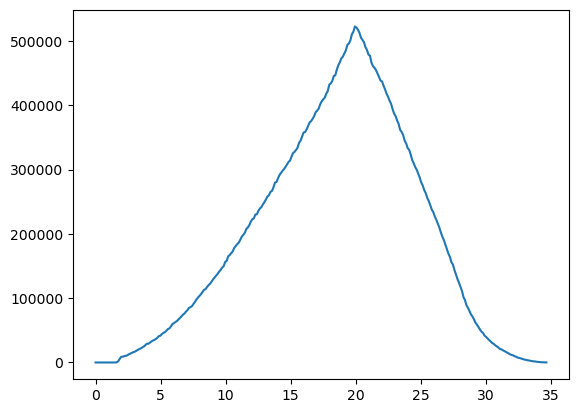

In [43]:
r = np.linspace(0, np.sqrt(3)*cutoff, n_bins)

plt.figure()
plt.plot(r, gr)

print(p.cutoff_pbc)

In [38]:
# @njit
def rdf(traj, lbox, cutoff, max_frames=10000, n_bins=300, rho=1):
    
    # rdf(p.trajectory, p.box_length, p.cutoff_pbc, max_frames, nbins)
        
    lbox2 = lbox/2
    natoms = len(traj[0])
    atom_indices = np.arange(natoms)    
    dr = np.sqrt(3)*cutoff/n_bins       # NOTE sqrt(3)*r_c because of cubic geometry

    if max_frames > len(traj):
        max_frames = len(traj)
    
    gr = np.zeros(n_bins)
    r = np.linspace(dr/2, np.sqrt(3)*cutoff-dr/2, n_bins)
    
    natoms_avg = 0
    
    for k, frame in enumerate(traj[len(traj)-max_frames:]): #take the last max_frames frames
        
        if k%100 == 0:
            print(f"{k:d}/{max_frames:d}")
        
        for i in range(natoms-1):

            # 1 shift atom i to center
            frame_shift = frame - frame[i]

            # 2 apply pbc
            frame_shift[frame_shift>lbox2] -= lbox
            frame_shift[frame_shift<-lbox2] += lbox
            
            # 3 calculate distance within cutoff
            
            # create index list that only contains atoms within cutoff
            atom_indices_in = atom_indices[np.all(np.logical_and(frame_shift < cutoff, frame_shift > -cutoff), axis=1)]
            
            natoms_avg += len(atom_indices_in)/natoms/max_frames
            
            # loop over all other atoms but self
            for j in atom_indices_in[atom_indices_in != i]:
                
                # since atom j now sits in 0 we dont deed to calculate the distance to it
                # but only the norm of the position of the surrounding atoms 
                d = np.sqrt(frame_shift[j, 0]**2 + frame_shift[j, 1]**2 + frame_shift[j, 2]**2)
                
                # 4 bin into rdf array
                gr[int(d/dr)] += 2
    
    print("N_avg", natoms_avg)
    #normalisation
    edges = np.linspace(0, np.sqrt(3)*cutoff-dr/2, n_bins+1)
    # for bin_idx in range(len(gr)):
    #     gr[bin_idx] = 4*np.pi*rho*gr[bin_idx]/max_frames/natoms_avg/3
    
    gr = 4*np.pi*rho*gr/(edges[1:]**3 - edges[:-1]**3)/max_frames/natoms_avg/3
    # normalisation (wrong)
    # gr = gr/np.sum(dr*gr)
                
    return r, gr

0/300
100/300
200/300


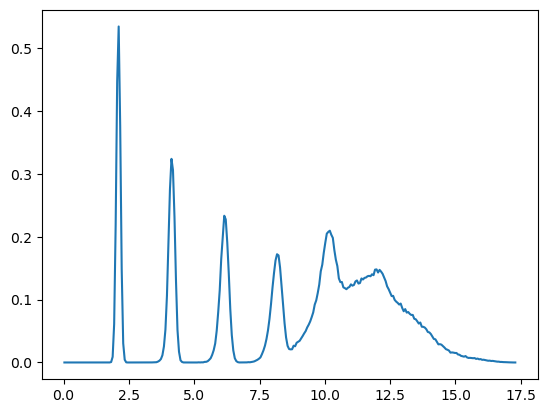

In [100]:
p.set_cutoff(p.box_length/4)
traj = p.trajectory
lbox = p.box_length
cutoff = p.cutoff_pbc

r, gr = rdf(traj, lbox, cutoff, max_frames=300)
plt.figure()
plt.plot(r, gr)

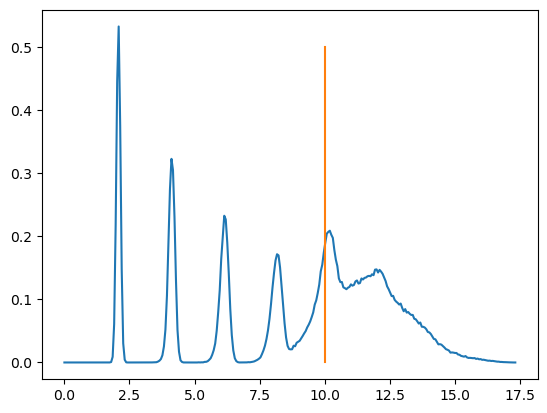

In [97]:
plt.figure()
plt.plot(r, gr/np.sum((r[1]-r[0])*gr))
plt.plot((cutoff, cutoff), (0, 0.5))


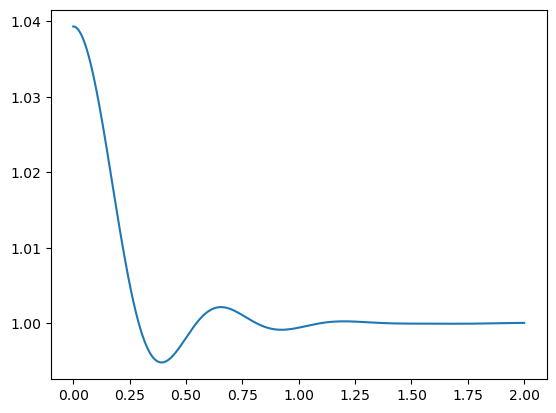

In [101]:
# dr = r[1]-r[0]
# gr = gr/np.sum((dr)*gr)
# r = np.linspace(dr/2, np.sqrt(3)*p.box_length/4-dr/2, 300)


Sq, q = Sq_rdf(gr+1, r, 1/100, qmax=2, n=512)

plt.figure()
plt.plot(q, Sq)

In [117]:
SQ = np.append([q], [Sq], axis = 0).T
RDF = np.append([r], [gr], axis = 0).T

#np.save("/home/jan/Documents/masterthesis/project/mucus/structure_factors/SQ.npy", SQ)
np.save("/home/jan/Documents/masterthesis/project/mucus/rdfs/RDF.npy", SQ)

In [107]:
import time
import datetime
def report_time(name = "caluclation", report_type = "start", starttime = None):
    if report_type == "start":
        now = time.localtime()
        now_str = f"{now.tm_mon:d}.{now.tm_mday}.{now.tm_year}  {now.tm_hour}:{now.tm_min}:{now.tm_sec}"
        print(f"\n{name:s} started ", now_str)
        return time.time() 

    if report_type == "end":
        now = time.localtime()
        now_str = f"{now.tm_mon:d}.{now.tm_mday}.{now.tm_year}  {now.tm_hour}:{now.tm_min}:{now.tm_sec}"
        print(f"{name:s} finished ", now_str)
        print(f"{name:s} time: ", datetime.timedelta(seconds=round(time.time()-starttime)))
        return
    
starttime = report_time()

report_time(report_type="end", starttime=starttime)


caluclation started  3.7.2023  20:15:43
caluclation finished  3.7.2023  20:15:48
caluclation time:  0:00:05


In [18]:
n_beeds = 4
positions = np.random.randn(n_beeds, 3)
r_left = np.tile(positions, (n_beeds, 1, 1)) # repeats vector along third dimension len(a) times
r_right = np.reshape(np.repeat(positions, n_beeds, 0), (n_beeds, n_beeds, 3)) # does the same but "flipped"
directions = r_left - r_right

print(directions)
print(directions.shape)
x = np.copy(directions)
print(x)
print(np.abs(x))
print(np.abs(x) < 0.6)
L = np.sum(np.abs(x) < 0.6, axis=2, dtype=bool)
print(L)

print(x[L])

[[[ 0.          0.          0.        ]
  [ 0.72512795  1.70142557  0.260391  ]
  [ 0.26847358  0.57933235  2.42306492]
  [-1.24546719  2.77648994  2.50817611]]

 [[-0.72512795 -1.70142557 -0.260391  ]
  [ 0.          0.          0.        ]
  [-0.45665437 -1.12209322  2.16267392]
  [-1.97059514  1.07506437  2.24778511]]

 [[-0.26847358 -0.57933235 -2.42306492]
  [ 0.45665437  1.12209322 -2.16267392]
  [ 0.          0.          0.        ]
  [-1.51394077  2.19715759  0.08511118]]

 [[ 1.24546719 -2.77648994 -2.50817611]
  [ 1.97059514 -1.07506437 -2.24778511]
  [ 1.51394077 -2.19715759 -0.08511118]
  [ 0.          0.          0.        ]]]
(4, 4, 3)
[[[ 0.          0.          0.        ]
  [ 0.72512795  1.70142557  0.260391  ]
  [ 0.26847358  0.57933235  2.42306492]
  [-1.24546719  2.77648994  2.50817611]]

 [[-0.72512795 -1.70142557 -0.260391  ]
  [ 0.          0.          0.        ]
  [-0.45665437 -1.12209322  2.16267392]
  [-1.97059514  1.07506437  2.24778511]]

 [[-0.26847358 -0.

#### RDF with MDtraj


In [ ]:
# calculate rdf using mdtraj

def rdf(self):
    fname_top = "/home/jan/Documents/masterthesis/project/mucus/topologies/polymer_160_beeds.pdb"
    fname_traj = "/home/jan/Documents/masterthesis/project/mucus/pres/trajectories/traj5.gro"

    topology = md.load(fname_top).topology

    traj_xyz = md.load(fname_traj).xyz
    natoms = len(traj_xyz[0])

    lbox = 40   # TODO

    # create unic cell information
    uc_vectors = np.repeat([np.array((lbox, lbox, lbox))], len(traj_xyz), axis=0)
    uc_angles = np.repeat([np.array((90,90,90))], len(traj_xyz), axis=0)


    trajectory = md.Trajectory(traj_xyz, topology, unitcell_lengths=uc_vectors, unitcell_angles=uc_angles)

    #delete again from ram TODO: delete this once in function
    traj_xyz = 0

    # create bond pair list
    pairs = list()
    for i in range(natoms-1):
        for j in range(i+1, natoms):
            pairs.append((i, j))
            
    pairs = np.array(pairs)

    r, gr = md.compute_rdf(trajectory, pairs, r_range=(1.5, 20), bin_width=0.05)
    
    return r, gr

In [2]:
# test sq and rdf using polymer class

fname_cfg = "/home/jan/Documents/masterthesis/project/mucus/pres/configs/cfg4.toml" # TODO DELETE

cfg = Config.from_toml(fname_cfg)

fname_traj = cfg.fname_traj
fname_traj = "/home/jan/Documents/masterthesis/project/mucus/pres/trajectories/traj4.gro" # TODO DELETE

p = Polymer(cfg)
p.load_traj_gro(fname_traj, overwrite=True)

r, gr = p.rdf()
q, Sq = p.get_structure_factor_rdf(radii=r, g_r=gr)


#### plot shit

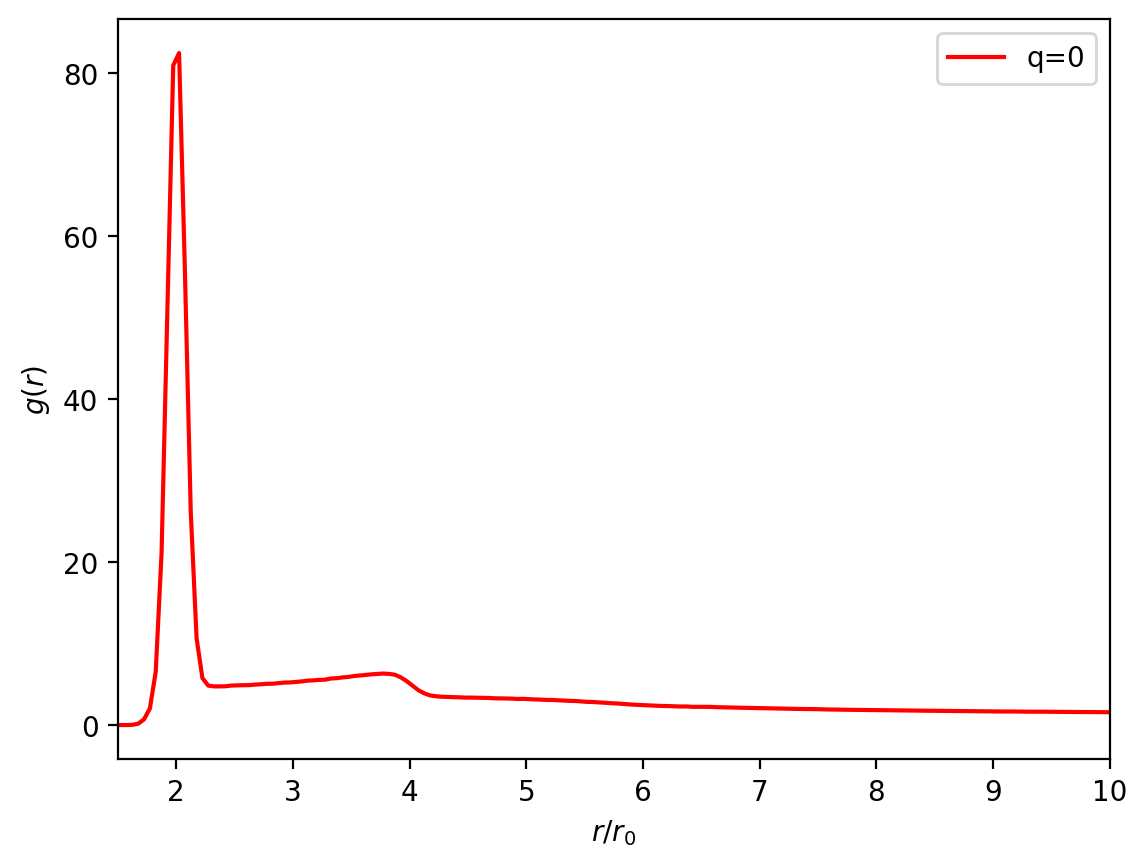

In [16]:

plt.figure(dpi=200)
plt.plot(r, gr, "r", label="no charge")
plt.xlabel(r"$r/r_0$")
plt.ylabel(r"$g(r)$")
plt.xlim((1.5, 10))
plt.legend()
plt.show()


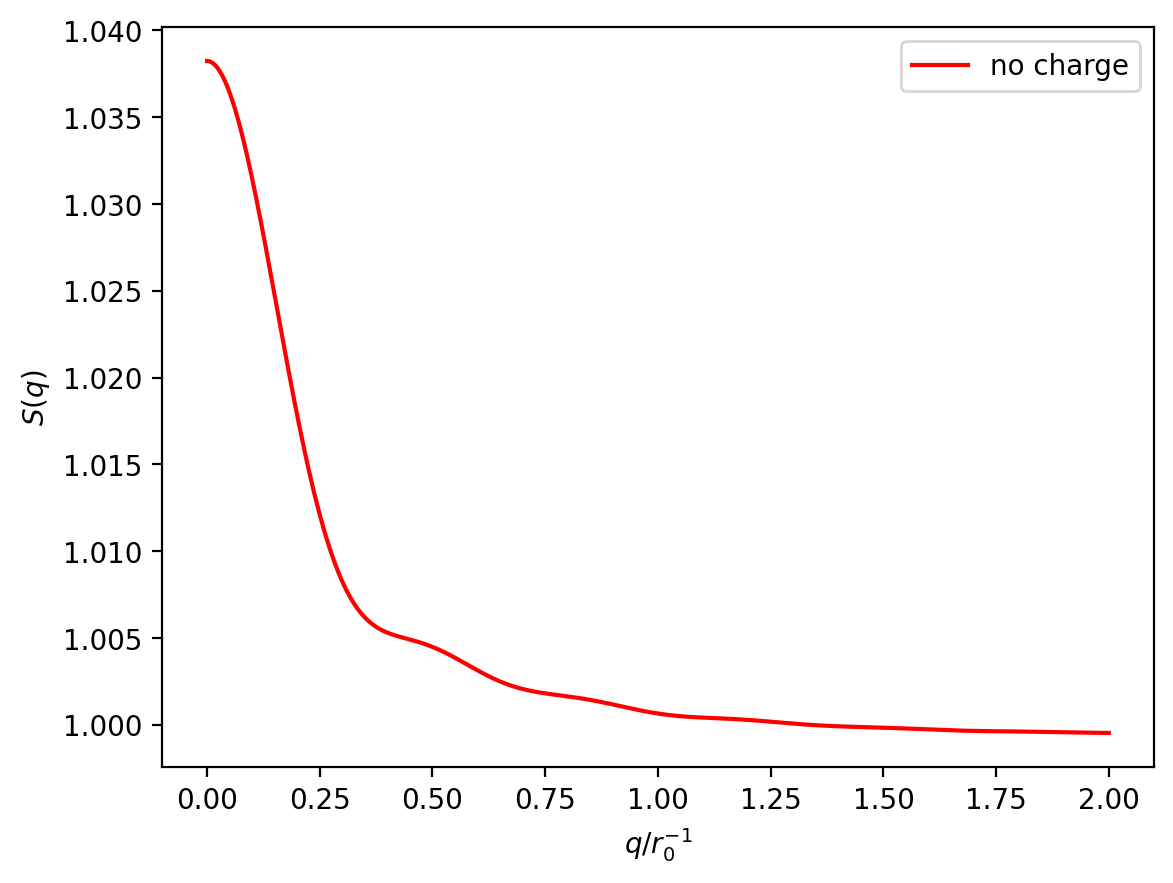

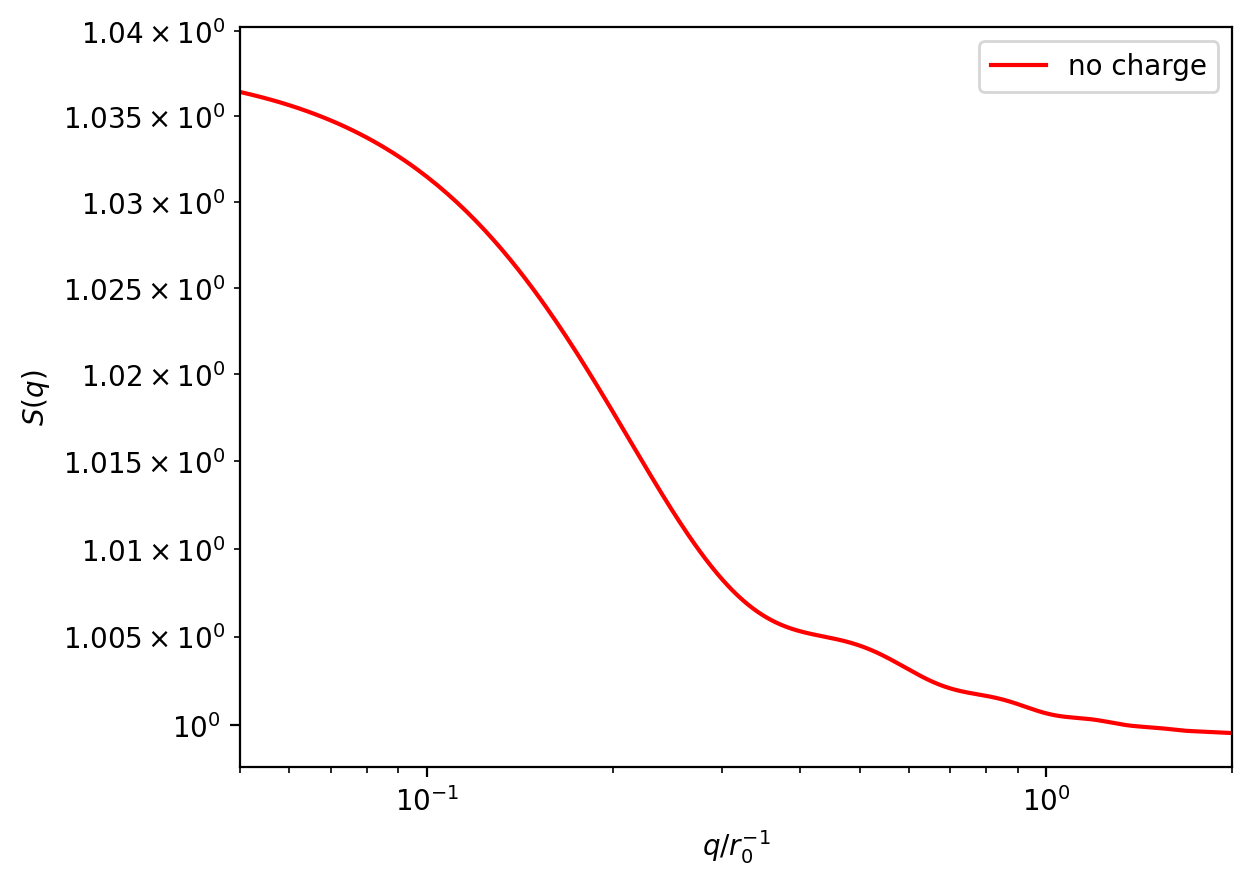

In [21]:
plt.figure(dpi=200)
plt.plot(q, Sq, "r", label="no charge")
plt.xlabel(r"$q/r_0^{-1}$")
plt.ylabel(r"$S(q)$")
#plt.xlim((1.5, 10))
plt.legend()
plt.show()


plt.figure(dpi=200)
plt.loglog()
plt.plot(q, Sq, "r", label="no charge")
plt.xlabel(r"$q/r_0^{-1}$")
plt.ylabel(r"$S(q)$")
plt.xlim((0.5e-1, 2))
plt.legend()
plt.show()
# plt.figure()
# plt.loglog()
# plt.plot(q, Sq)
# plt.xlim((2e-1, 2))
# plt.show()

In [13]:
fname_cfg = "/home/jan/Documents/masterthesis/project/mucus/pres/configs/cfg5.toml" # TODO DELETE

cfg = Config.from_toml(fname_cfg)

fname_traj = "/home/jan/Documents/masterthesis/project/mucus/pres/trajectories/traj5.gro" # TODO DELETE

p2 = Polymer(cfg)
p2.load_traj_gro(fname_traj, overwrite=True)

r2, gr2 = p2.rdf()
q2, Sq2 = p2.get_structure_factor_rdf(radii=r2, g_r=gr2)

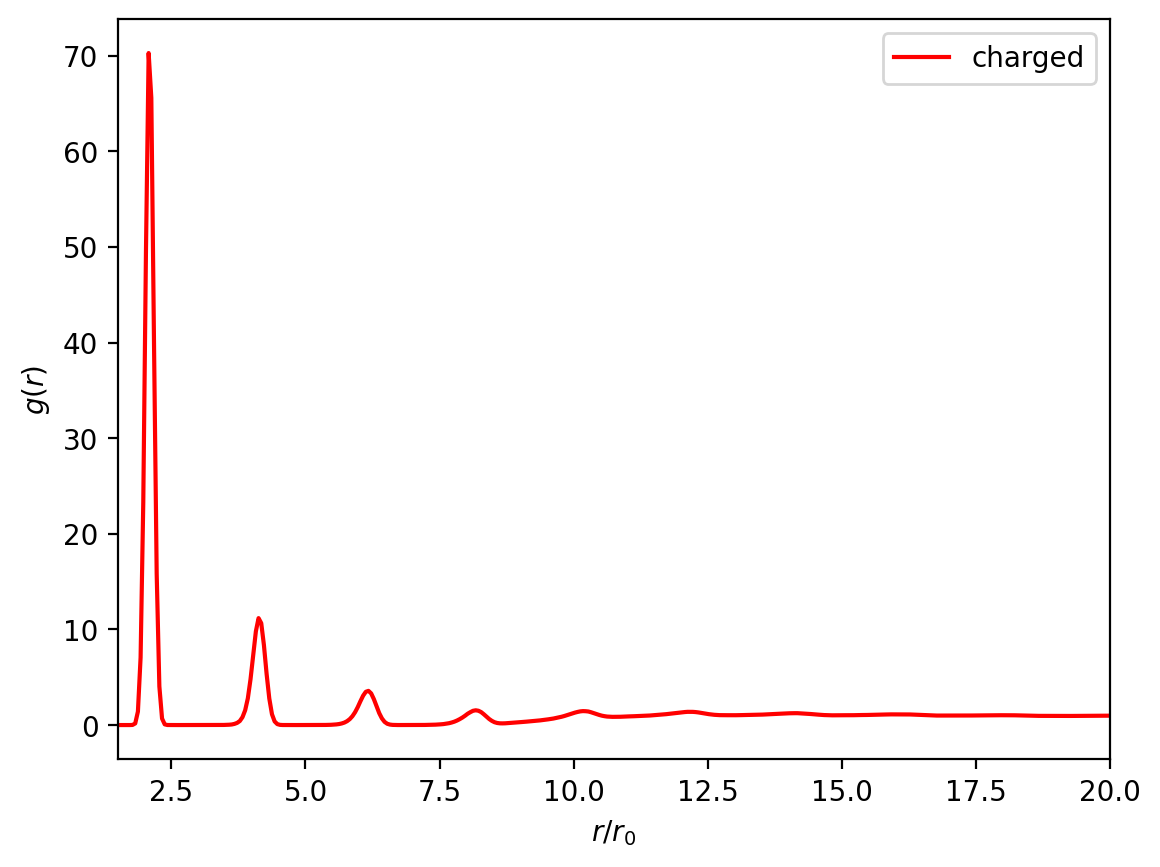

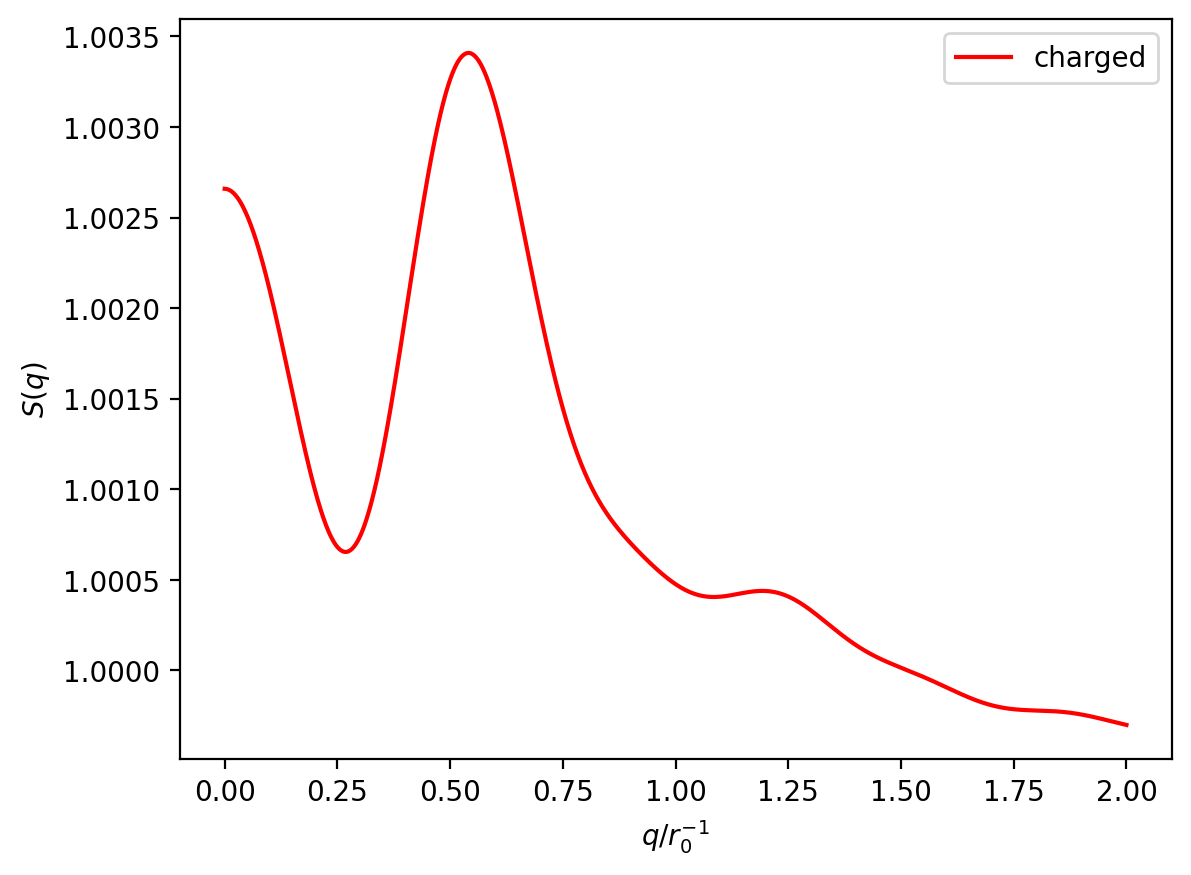

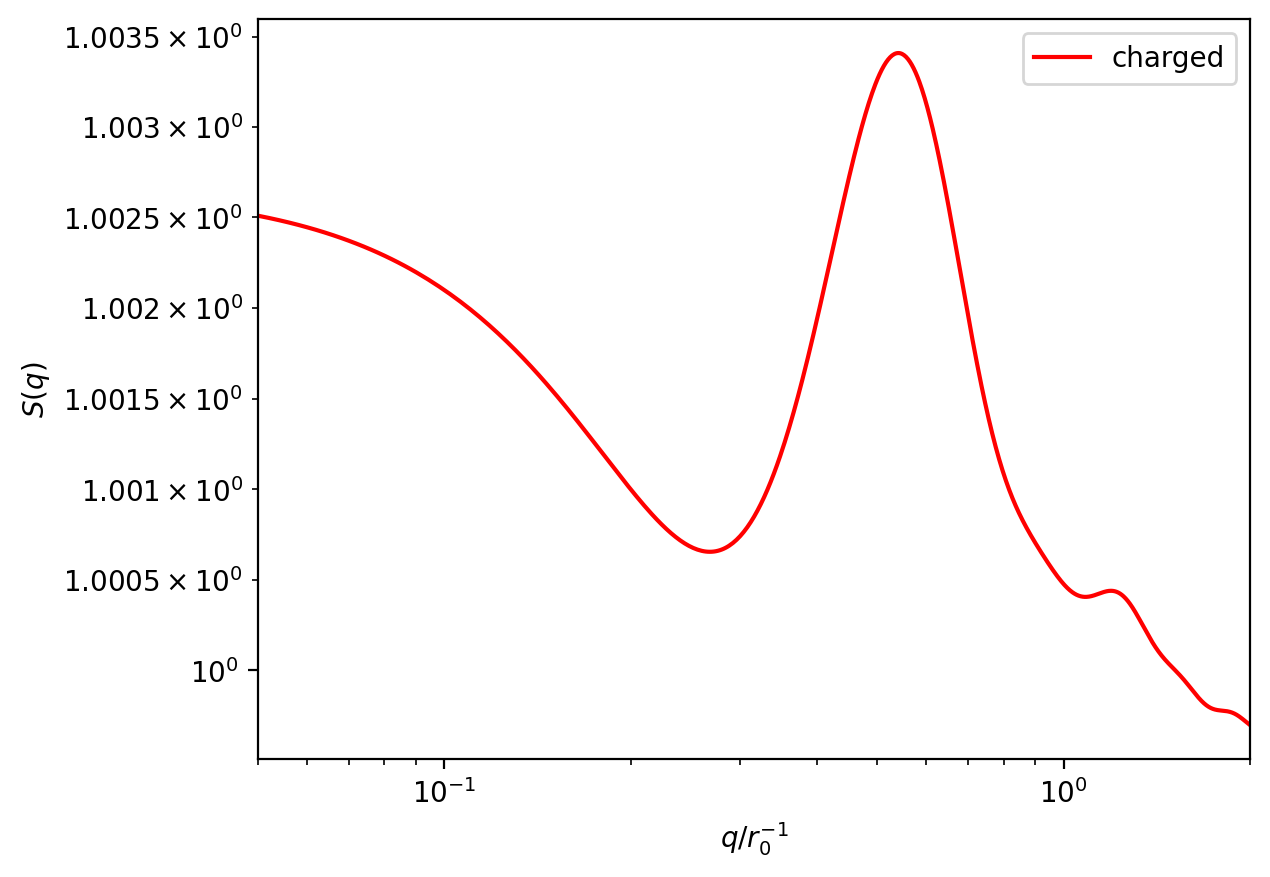

In [24]:
plt.figure(dpi=200)
plt.plot(r2, gr2, "r", label="charged")
plt.xlabel(r"$r/r_0$")
plt.ylabel(r"$g(r)$")
plt.xlim((1.5, 20))
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.plot(q2, Sq2, "r", label="charged")
plt.xlabel(r"$q/r_0^{-1}$")
plt.ylabel(r"$S(q)$")
#plt.xlim((1.5, 10))
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.loglog()
plt.plot(q2, Sq2, "r", label="charged")
plt.xlabel(r"$q/r_0^{-1}$")
plt.ylabel(r"$S(q)$")
plt.xlim((0.5e-1, 2))
plt.legend()
plt.show()

In [128]:
def compute_rdf(traj, pairs, r_range=None, bin_width=0.005, n_bins=None,
                periodic=True, opt=True):

    if r_range is None:
        r_range = np.array([0.0, 1.0])
    # r_range = ensure_type(r_range, dtype=np.float64, ndim=1, name='r_range',
    #                       shape=(2,), warn_on_cast=False)
    if n_bins is not None:
        n_bins = int(n_bins)
        if n_bins <= 0:
            raise ValueError('`n_bins` must be a positive integer')
    else:
        n_bins = int((r_range[1] - r_range[0]) / bin_width)

    distances = md.compute_distances(traj, pairs, periodic=periodic, opt=opt)
    g_r, edges = np.histogram(distances, range=r_range, bins=n_bins)
    r = 0.5 * (edges[1:] + edges[:-1])

    # Normalize by volume of the spherical shell.
    # See discussion https://github.com/mdtraj/mdtraj/pull/724. There might be
    # a less biased way to accomplish this. The conclusion was that this could
    # be interesting to try, but is likely not hugely consequential. This method
    # of doing the calculations matches the implementation in other packages like
    # AmberTools' cpptraj and gromacs g_rdf.
    V = (4 / 3) * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
    norm = len(pairs) * np.sum(1.0 / traj.unitcell_volumes) * V
    g_r = g_r.astype(np.float64) / norm  # From int64.
    
    
    return r, g_r

None
40.0


In [145]:
distances = md.compute_distances(trajectory[0], pairs, periodic=True, opt=True)
print(distances)
print(trajectory[0].xyz)

[[2. 4. 6. ... 2. 4. 2.]]
[[[10.  1. 10.]
  [10.  3. 10.]
  [10.  5. 10.]
  [10.  7. 10.]
  [10.  9. 10.]
  [10. 11. 10.]
  [10. 13. 10.]
  [10. 15. 10.]
  [10. 17. 10.]
  [10. 19. 10.]
  [10. 21. 10.]
  [10. 23. 10.]
  [10. 25. 10.]
  [10. 27. 10.]
  [10. 29. 10.]
  [10. 31. 10.]
  [10. 33. 10.]
  [10. 35. 10.]
  [10. 37. 10.]
  [10. 39. 10.]
  [20.  1. 10.]
  [20.  3. 10.]
  [20.  5. 10.]
  [20.  7. 10.]
  [20.  9. 10.]
  [20. 11. 10.]
  [20. 13. 10.]
  [20. 15. 10.]
  [20. 17. 10.]
  [20. 19. 10.]
  [20. 21. 10.]
  [20. 23. 10.]
  [20. 25. 10.]
  [20. 27. 10.]
  [20. 29. 10.]
  [20. 31. 10.]
  [20. 33. 10.]
  [20. 35. 10.]
  [20. 37. 10.]
  [20. 39. 10.]
  [30.  1. 10.]
  [30.  3. 10.]
  [30.  5. 10.]
  [30.  7. 10.]
  [30.  9. 10.]
  [30. 11. 10.]
  [30. 13. 10.]
  [30. 15. 10.]
  [30. 17. 10.]
  [30. 19. 10.]
  [30. 21. 10.]
  [30. 23. 10.]
  [30. 25. 10.]
  [30. 27. 10.]
  [30. 29. 10.]
  [30. 31. 10.]
  [30. 33. 10.]
  [30. 35. 10.]
  [30. 37. 10.]
  [30. 39. 10.]
  [ 1. 10. 20.

In [150]:
r, gr = md.compute_rdf(trajectory, pairs, r_range=(1.5, 20), bin_width=0.05)

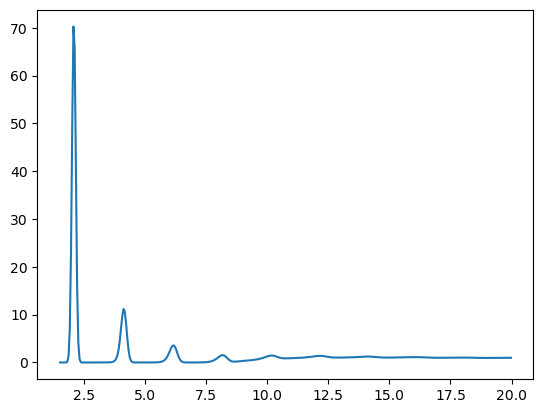

In [151]:
plt.figure()
plt.plot(r, gr)
plt.show()

In [157]:
rho = len(pairs) * np.sum(1.0 / trajectory.unitcell_volumes) / natoms / len(trajectory)
print(rho)

0.0012421875502238117


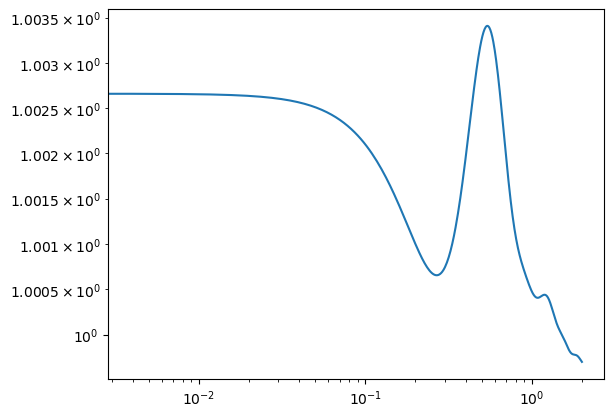

In [158]:
Sq, q = Sq_rdf(gr, r, rho, qmax=2, n=512)

plt.figure()
plt.loglog()
plt.plot(q, Sq)

plt.show()

In [90]:
fname_cfg = "/home/jan/Documents/masterthesis/project/mucus/pres/configs/cfg5.toml"
fname_traj = "/home/jan/Documents/masterthesis/project/mucus/pres/trajectories/traj5.gro"
cfg = Config.from_toml(fname_cfg)
p = Polymer(cfg)
p.load_traj_gro(fname_traj, overwrite=True)
traj = p.trajectory
lbox = p.box_length
cutoff = p.cutoff_pbc


r, gr = rdf(traj, lbox, cutoff*4, max_frames=500)
plt.figure()
plt.plot(r, gr)
# plt.xlim((4, 12))
# plt.ylim((0, 2))
plt.show()

KeyboardInterrupt: 

In [105]:
np.isclose(r, 20, atol=dr/2)

np.where(np.isclose(r, 20, atol=dr/2))[0][0]

98

160


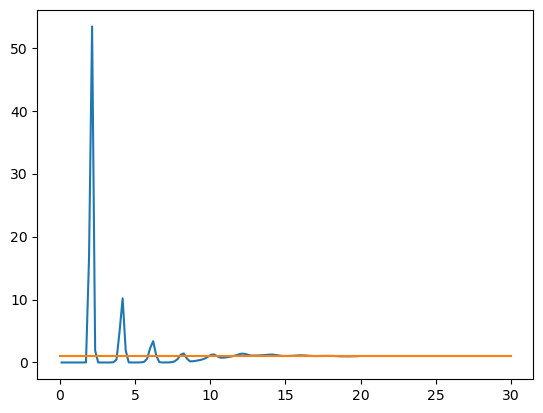

In [117]:
print(p.n_beeds)
dr = r[1] - r[0]
idx_end = np.where(np.isclose(r, 20, atol=dr/2))[0][0]
r_cut = r[:idx_end]
gr_cut = gr[:idx_end]*12
plt.figure()
plt.plot(r_cut, gr_cut)
# plt.xlim((4, 30))
# plt.ylim((0, 2))
plt.plot((0,30), (1,1))
plt.show()

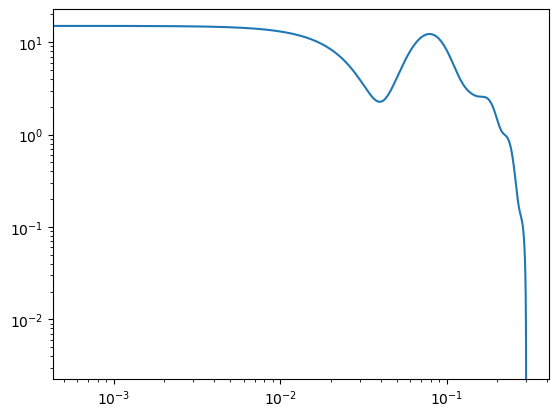

In [122]:
Sq, q = Sq_rdf(gr_cut, r_cut, 1, qmax=2, n=512)

plt.figure()
plt.loglog()
plt.plot(q*0.15, Sq)

plt.show()

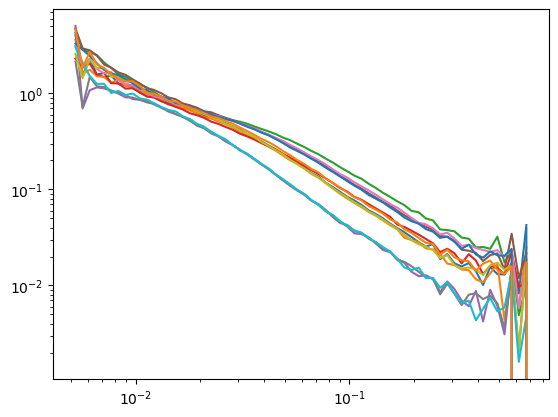

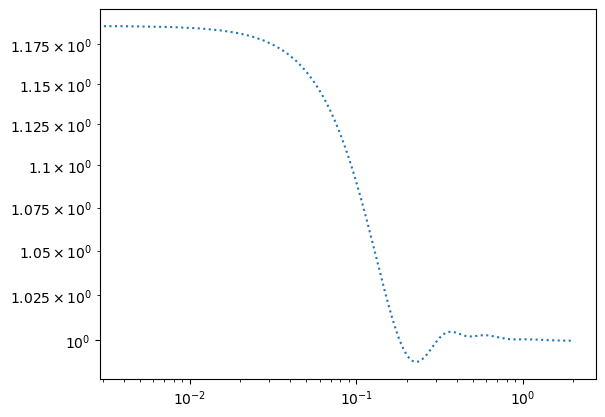

In [123]:
dir_exp = "/home/jan/Documents/masterthesis/project/mucus/exp_data/sans_nov22_PEG/"

fnames_exp = list()

for file in os.listdir(dir_exp):
     filename = os.fsdecode(file)
     if filename.endswith(".txt"): 
         fnames_exp.append(os.path.join(dir_exp, filename))
     else:
         continue

Sq, q = Sq_rdf(gr+1, r, 1/100, qmax=2, n=512)

plt.figure()
plt.loglog()

for k, fname_exp in enumerate(fnames_exp):
    data = np.loadtxt(fname_exp, skiprows=5)
    q_exp = data[:, 0]
    Sq_exp = data[:, 1]
    plt.plot(q_exp, Sq_exp)
# plt.xlim((0, 0.4))
# plt.ylim((1e-2, 8))
#plt.plot(q, 1000*Sq, ":")
plt.show()
plt.figure()
plt.loglog()
plt.plot(q, Sq, ":")
plt.xlim()
plt.show()
# fname_SQ = "/home/jan/Documents/masterthesis/project/mucus/pres/calculations/RDF_no_charges.npy"
# SQ = np.load(fname_SQ)

# q = SQ[:, 0]
# Sq = SQ[:, 1]

# plt.figure()
# plt.plot(q, Sq)
# plt.show()


# @mpltex.aps_decorator
# def myplot():
#     plt.figure(dpi=200)
#     plt.plot(q, Sq, label='no charges')
#     plt.xlabel(r'$q$')
#     plt.ylabel(r'$S(q)$')
#     plt.legend()
#     plt.show()
    
# myplot()